# Performance Prediction Analysis

## Questions/Ideas
- model selection: which method?
- difficult to select good bandwidth programmatically
- developement of prediction interval: from few to many data points

In [64]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import scipy.interpolate
import pandas as pd

import sklearn as skl
import sklearn.linear_model, sklearn.pipeline, sklearn.cross_validation, sklearn.gaussian_process

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import os

In [4]:
def fmap(x):
    return np.c_[np.ones_like(x), 1./x]

def ols(x, y, x_predict, fmap, plot=False, ax=None):

    # fit OLS
    X = fmap(x)
    ols_model = sm.OLS(y, X)
    result = ols_model.fit()

    # predict OLS
    X_predict = fmap(x_predict)
    y_predict = result.predict(X_predict)
    prstd, iv_l, iv_u = wls_prediction_std(result, exog=X_predict)
    
    # plot OLS
    if plot:
        if ax is None:
            ax = plt.gca()    

        ax.fill_between(x_predict, iv_u, iv_l, color='gray', alpha=.2, label='95% PI')
        ax.plot(x, y, 'x', label='data')
        ax.plot(x_predict, y_predict, 'r', label='OLS')
        ax.legend()

        return result, ax
    
    return result

In [5]:
def ols_experiment(x, y, idxs, fmap):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = 0, y.max()*1.5
    
    x_predict = np.linspace(x.min(), x.max(), 100)
    
    plt.figure(figsize=(13,3))
    for i, idx in enumerate(idxs):
        xi, yi = x[idx], y[idx]
        ax = plt.subplot(1, len(idxs), i+1)
        ols(xi, yi, x_predict, fmap, plot=True, ax=ax)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    
    plt.tight_layout()
    plt.show()

In [6]:
def remove_outlier_runs(data):
    x, y = data[:,0], data[:,1]
    data_wo = []
    for so in np.unique(x):
        rt = np.sort(data[x==so,1])[1:-1]
        data_wo.append(np.c_[so*np.ones_like(rt),rt])
    return np.vstack(data_wo)

## Developement of the Prediction Interval with Increasing Amount of Data

The following plots demostrate that an early prediction interval (PI) might not reflect the true uncertainity behind the runtimes.

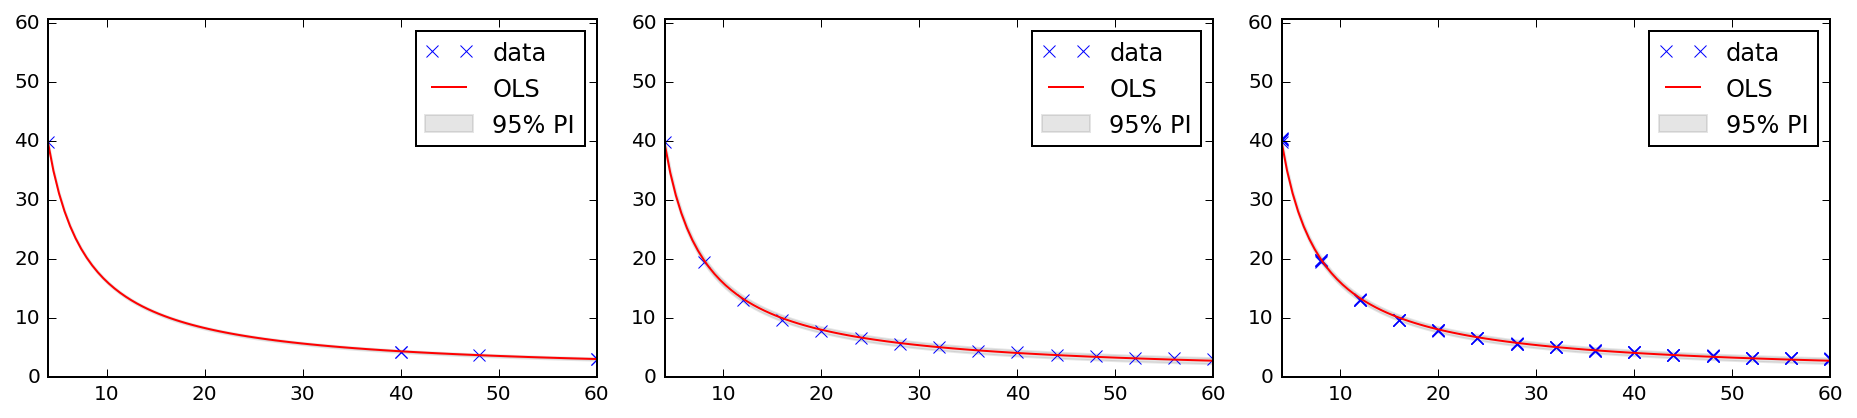

In [115]:
np.random.seed(10000)

df = pd.read_csv('data/wordcount.flink.csv')
data = df.values
data = remove_outlier_runs(data)

x, y = data[:,0], data[:,1]/60000.

idx1 = np.random.permutation(x.size)[:6]
idx2 = np.arange(0, x.size, 5)
idx3 = np.arange(x.size)

ols_experiment(x, y, [idx1, idx2, idx3], fmap)

## Plot Runtimes

In [239]:
class Regression:
    def fit(self, X, y):
        raise NotImplemented()
    
    def predict(self, X):
        raise NotImplemented()
    
class SimpleOLSRegression(Regression):
    def __init__(self, fmap):
        self.fmap = fmap
        
    def fit(self, x, y):
        X = self.fmap(x)
        ols_model = sm.OLS(y, X)
        self.result = ols_model.fit()
        
    def predict(self, x):
        X = self.fmap(x)
        return self.result.predict(X)
    
class SimpleKernelRegression(Regression):
    def fit(self, x, y):
        # TODO: select bandwidth
        self.kr = sm.nonparametric.KernelReg(y, x, 'c', reg_type='ll', bw=[3.])
        
    def predict(self, x):
        y, _ = self.kr.fit(x)
        return y
    
class SimpleGPRegression(Regression):
    def __init__(self):
        self.gp = skl.gaussian_process.GaussianProcess()#theta0=1e-1, thetaL=1e-8, thetaU=200, nugget=(sig_y/y)**2)
        
    def fit(self, x, y):
        xu = np.unique(x)
        yu = []
        for so in xu:
            yu.append(np.mean(y[x==so]))
        self.gp.fit(np.atleast_2d(xu).T, yu)
        
    def predict(self, x):
        X_predict = np.atleast_2d(x).T
        y_predict = self.gp.predict(X_predict)
        return y_predict
    
class SimpleCVModelSection(Regression):
    def __init__(self, regressions):
        self.regressions = regressions
        
    def fit(self, x, y):
        # create data folds
        sos = np.unique(x)
        folds = []
        for so in sos[1:-1]:
            rts = y[x==so]
            folds.append(np.c_[so*np.ones_like(rts), rts])
            
        # perform cv
        errs = np.zeros((len(folds),len(self.regressions)))
        for i in range(len(folds)):
            data_test = folds[i]
            x_test, y_test = data_test[:,0], data_test[:,1]
            data_train = np.vstack(folds[:i]+folds[i+1:])
            x_train, y_train = data_train[:,0], data_train[:,1]

            
            for j, reg in enumerate(self.regressions):
                reg.fit(x_train, y_train)
                y_predict = reg.predict(x_test)
                mse = np.mean((y_predict - y_test)**2)
                
                errs[i,j] = mse
        
        # select best model
        mean_errs = np.mean(errs, axis=0)
        reg_idx = np.argmin(mean_errs)
        reg_opt = self.regressions[reg_idx]
        
        self.regression = reg_opt
        self.regression.fit(x, y)
        
    def predict(self, x):
        return self.regression.predict(x)
    
class SimpleRSModelSection(Regression):
    def __init__(self, para, nonpara, threshold=.97):
        self.para = para
        self.nonpara = nonpara
        self.threshold = threshold
        
    def fit(self, x, y):
        y_mean = np.mean(y)
        self.para.fit(x, y)
        y_predict = self.para.predict(x)
        ss_res = np.sum((y_predict-y)**2)
        ss_tot = np.sum((y_mean-y)**2)
        self.rs = 1 - ss_res/ss_tot

        if self.rs > self.threshold:
            self.regression = self.para
        else:
            self.regression = self.nonpara
            self.regression.fit(x, y)
        
    def predict(self, x):
        return self.regression.predict(x)
    
class SimpleSegmentedRegression(Regression):
    def __init__(self):
        pass
    
    def _fit(self, x, y, knot):        
        x1, y1 = x[x<knot], y[x<knot]
        x2, y2 = x[x>=knot], y[x>=knot]

        # first model is inverse
        X1 = np.c_[np.ones_like(x1), 1./x1]
        ols_model1 = sm.OLS(y1, X1)
        result1 = ols_model1.fit()

        # second model is linear
        X2 = np.c_[np.ones_like(x2), x2]
        ols_model2 = sm.OLS(y2, X2)
        result2 = ols_model2.fit()
        
        return result1, result2
        
    def _predict(self, x, knot, result1, result2):
        x1, x2 = x[x<knot], x[x>=knot]
        
        # predict and plot
        X1_predict = np.c_[np.ones_like(x1), 1./x1]
        y1_predict = result1.predict(X1_predict)

        X2_predict = np.c_[np.ones_like(x2), x2]
        y2_predict = result2.predict(X2_predict)
        
        return np.r_[y1_predict, y2_predict]
        
    def fit(self, x, y):
        xu = np.unique(x)
        xu_diff = np.diff(xu)
        knots = xu[:-1] + xu_diff/2.
        
        # perform cv to select best knot
        mses = []
        rs = []
        for knot in knots:
            r1, r2 = self._fit(x, y, knot)
            y_predict = self._predict(x, knot, r1, r2)
            mse = np.mean((y_predict-y)**2)
            
            rs.append((r1,r2))
            mses.append(mse)
            
        # select best knot and corresponding results  
        self.knot = knots[np.argmin(mses)]
        self.r1, self.r2 = rs[np.argmin(mses)]
        
    def predict(self, x):
        return self._predict(x, self.knot, self.r1, self.r2)

In [231]:
def get_data(dataset):
    df = pd.read_csv(dataset)
    data = df.values
    data = remove_outlier_runs(data)
    x, y = data[:,0], data[:,1]/60000.
    return x, y

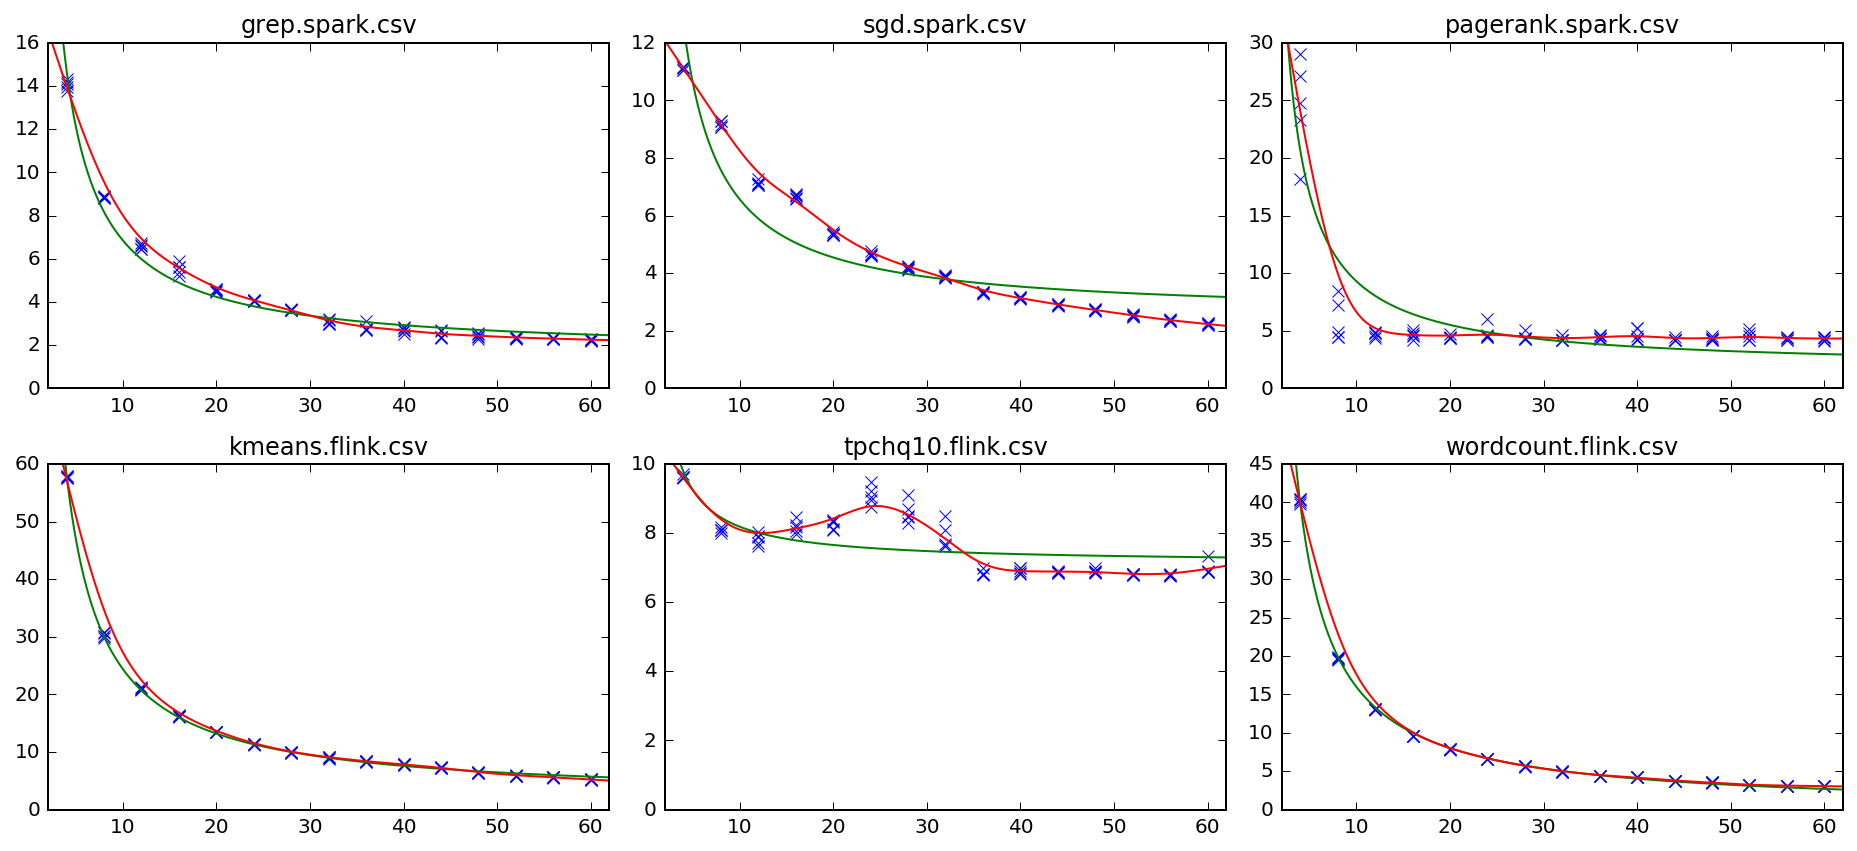

In [242]:
dpath = 'data/'
fnames = ['grep.spark.csv', 'sgd.spark.csv', 'pagerank.spark.csv', 
          'kmeans.flink.csv', 'tpchq10.flink.csv', 'wordcount.flink.csv']
ols_regression = SimpleOLSRegression(fmap=lambda x:np.c_[np.ones_like(x),1./x])
kr_regression = SimpleKernelRegression()
models = [ols_regression, kr_regression]

#gp_regression = SimpleGPRegression();models=[ols_regression,gp_regression]
#seg_regression = SimpleSegmentedRegression();models=[ols_regression,seg_regression]

plt.figure(figsize=(13,6))

for i, fname in enumerate(fnames):
    fpath = os.path.join(dpath, fname)
    x, y = get_data(fpath)
    plt.subplot(2,3,i+1)
    plt.title(fnames[i])
    plt.plot(x, y, 'x')
    plt.xlim(2, 62)
    plt.ylim(ymin=0)

    x_predict = np.linspace(2, 62, 2000)
    for reg in models:
        reg.fit(x, y)
        y_predict = reg.predict(x_predict)
        plt.plot(x_predict, y_predict)
    
plt.tight_layout()    
plt.show()

## Cross-Validation (Repeated Random Sub-Sampling)

In [195]:
def _select_random_scaleouts(scaleouts, n):
    while True:
        train_so = np.random.choice(scaleouts, size=n, replace=False)
        test_range = np.arange(train_so.min(), train_so.max())
        test_range = np.intersect1d(test_range, scaleouts)
        test_range = np.setdiff1d(test_range, train_so)
        if test_range.size == 0:
            continue
        return train_so, np.atleast_1d(np.random.choice(test_range))

def __select_random_scaleouts(scaleouts, n):
    s = np.random.randint(len(scaleouts)-(n+1))
    so = scaleouts[s:s+(n+1)]
    test_so_idx = np.random.randint(1,len(so)-1)
    
    train_so = np.r_[so[:test_so_idx],so[test_so_idx+1:]]
    test_so = np.atleast_1d(so[test_so_idx])
    
    return train_so, test_so

print _select_random_scaleouts(np.unique(x), 3)

def _select_random_runtimes(train, test, x, y):
    scaleouts = np.r_[train, test]
    rs = []
    for so in scaleouts:
        runtimes = y[x==so]
        runtime = np.random.choice(runtimes)
        rs.append(runtime)
    rs = np.array(rs)
    return rs[:len(train)], rs[len(train):]
    
def split_cv_stochastic(regression, x, y, n, iterations=1000):
    xu = np.unique(x)
    
    sqerrs = []
    for i in range(iterations):
    
        train_so, test_so = _select_random_scaleouts(xu, n)
        train_rt, test_rt = _select_random_runtimes(train_so, test_so, x, y)
    
        regression.fit(train_so, train_rt)
        predict_rt = regression.predict(test_so)
    
        sqerr = np.sum((test_rt - predict_rt)**2)
        sqerrs.append(sqerr)

        #if sqerr > 40:
        #    plt.plot(train_so, train_rt, 'bx')
        #    plt.plot(test_so, test_rt, 'ro')
        #    x_predict = np.linspace(train_so.min(),train_so.max())
        #    plt.plot(x_predict, regression.predict(x_predict))
        #    plt.show()
        #    return
    
    print 'MSE: %.4f (%.4f)' % (np.mean(sqerrs), np.std(sqerrs))
    return sqerrs

(array([16,  8,  4]), array([12]))


In [ ]:
n = 4

ols_regression = SimpleOLSRegression(fmap=lambda x:np.c_[np.ones_like(x),1./x])
ols_sqerrs = split_cv_stochastic(ols_regression, x, y, n)

kr_regression = SimpleKernelRegression()
kr_sqerrs = split_cv_stochastic(kr_regression, x, y, n)

plt.boxplot([ols_sqerrs, kr_sqerrs], showfliers=False, showmeans=True)
plt.show()

Scaleouts = 5
MSE: 0.4987 (0.6401)
MSE: 0.5500 (0.8601)
MSE: 0.9465 (5.1336)
MSE: 0.8155 (3.3650)
Scaleouts = 6
MSE: 0.4673 (0.6240)
MSE: 0.5562 (0.8404)
MSE: 0.5858 (2.3280)
MSE: 0.6060 (2.6495)
Scaleouts = 7
MSE: 0.4667 (0.5920)
MSE: 0.5482 (0.7883)
MSE: 0.3734 (0.7191)
MSE: 0.4254 (0.7012)
Scaleouts = 8
MSE: 0.4155 (0.5422)
MSE: 0.5127 (0.7804)
MSE: 0.3242 (0.6302)
MSE: 0.3764 (0.6098)
Scaleouts = 9
MSE: 0.4012 (0.5442)
MSE: 0.4359 (0.6503)
MSE: 0.2582 (0.4703)
MSE: 0.3465 (0.6000)
Scaleouts = 10
MSE: 0.3815 (0.5070)
MSE: 0.4416 (0.6708)
MSE: 0.2290 (0.4077)
MSE: 0.2790 (0.4896)
Scaleouts = 11
MSE: 0.4020 (0.5214)
MSE: 0.4910 (0.7215)
MSE: 0.1996 (0.3594)
MSE: 0.2251 (0.3969)
Scaleouts = 12
MSE: 0.3851 (0.5190)
MSE: 0.4492 (0.6255)
MSE: 0.1766 (0.2648)
MSE: 0.1884 (0.3345)
Scaleouts = 13
MSE: 0.3518 (0.4548)
MSE: 0.4804 (0.7426)
MSE: 0.1690 (0.2748)
MSE: 0.1661 (0.2861)


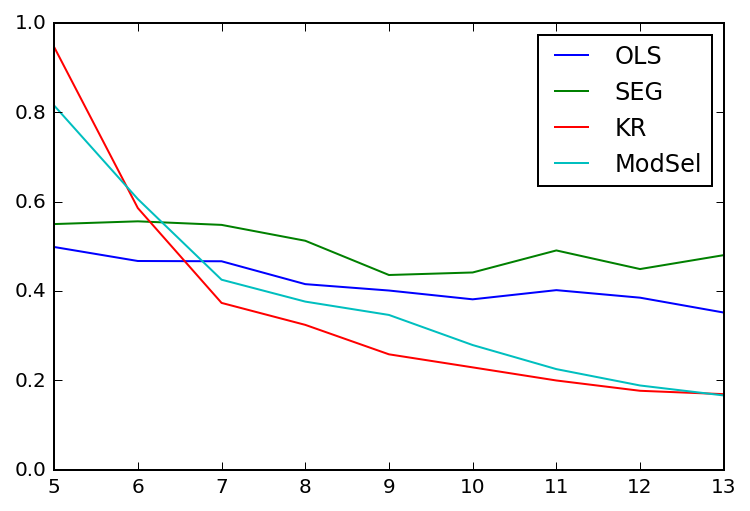

In [246]:
x, y = get_data('data/tpchq10.flink.csv')

ols_stats = []
seg_stats = []
kr_stats = []
gp_stats = []
modsel_stats = []

ns = range(5, 14)
for i in ns:
    
    print 'Scaleouts =', i
    
    ols_regression = SimpleOLSRegression(fmap=lambda x:np.c_[np.ones_like(x),x])
    ols_sqerrs = split_cv_stochastic(ols_regression, x, y, i)
    ols_stats.append((np.mean(ols_sqerrs), np.std(ols_sqerrs)))
    
    seg_regression = SimpleSegmentedRegression()
    seg_sqerrs = split_cv_stochastic(seg_regression, x, y, i)
    seg_stats.append((np.mean(seg_sqerrs), np.std(seg_sqerrs)))
    
    kr_regression = SimpleKernelRegression()
    kr_sqerrs = split_cv_stochastic(kr_regression, x, y, i)
    kr_stats.append((np.mean(kr_sqerrs), np.std(kr_sqerrs)))
    
    #gp_regression = SimpleGPRegression()
    #gp_sqerrs = split_cv_stochastic(gp_regression, x, y, i)
    #gp_stats.append((np.mean(gp_sqerrs), np.std(gp_sqerrs)))
    
    modsel_regression = SimpleCVModelSection([SimpleOLSRegression(fmap=lambda x:np.c_[np.ones_like(x),1./x]),
                                              SimpleKernelRegression()])
    modsel_sqerrs = split_cv_stochastic(modsel_regression, x, y, i)
    modsel_stats.append((np.mean(modsel_sqerrs), np.std(modsel_sqerrs)))
    
ols_stats = np.array(ols_stats)
seg_stats = np.array(seg_stats)
kr_stats = np.array(kr_stats)
gp_stats = np.array(gp_stats)
modsel_stats = np.array(modsel_stats)

#plt.errorbar(ns, ols_stats[:,0], ols_stats[:,1])
#plt.errorbar(ns, kr_stats[:,0], kr_stats[:,1])
plt.plot(ns, ols_stats[:,0], label='OLS')
plt.plot(ns, seg_stats[:,0], label='SEG')
plt.plot(ns, kr_stats[:,0], label='KR')
#plt.plot(ns, gp_stats[:,0], label='GP')
plt.plot(ns, modsel_stats[:,0], label='ModSel')
plt.ylim(ymin=0)
plt.legend()
plt.show()

## Segemented Regression

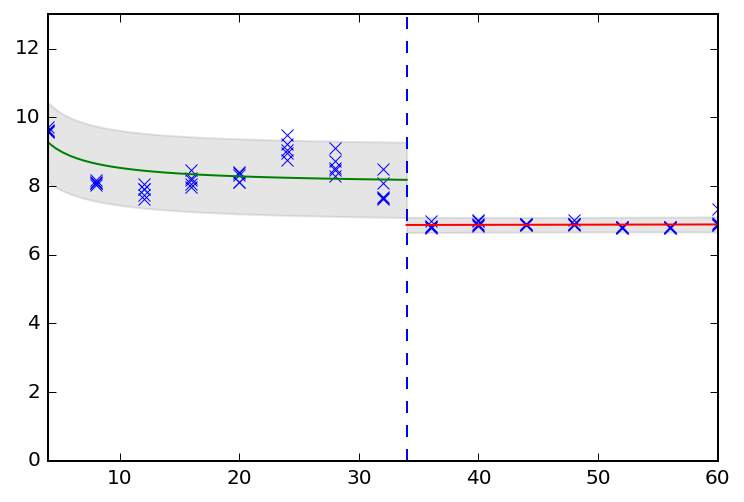

In [220]:
def segmented_ols(data, knot):
    x, y = data[:,0], data[:,1]/60000.
    
    x1, y1 = x[x<knot], y[x<knot]
    x2, y2 = x[x>=knot], y[x>=knot]
    
    # first model is inverse
    X1 = np.c_[np.ones_like(x1), 1./x1]
    ols_model1 = sm.OLS(y1, X1)
    result1 = ols_model1.fit()
        
    # second model is linear with fixed intercept
    x2 = x2 - knot
    X2 = np.c_[np.ones_like(x2), x2]
    ols_model2 = sm.OLS(y2, X2)
    result2 = ols_model2.fit()
    
    # predict and plot
    x1_predict = np.linspace(x1.min(), knot)
    X1_predict = np.c_[np.ones_like(x1_predict), 1./x1_predict]
    y1_predict = result1.predict(X1_predict)
    prstd1, iv_l1, iv_u1 = wls_prediction_std(result1, exog=X1_predict)
    
    x2_predict = np.linspace(0, x2.max())
    X2_predict = np.c_[np.ones_like(x2_predict), x2_predict]
    y2_predict = result2.predict(X2_predict)
    prstd2, iv_l2, iv_u2 = wls_prediction_std(result2, exog=X2_predict)

    
    plt.plot(x, y, 'x')
    plt.plot(x1_predict, y1_predict)
    plt.fill_between(x1_predict, iv_u1, iv_l1, color='gray', alpha=.2, label='95% PI')
    plt.plot(x2_predict+knot, y2_predict)
    plt.fill_between(x2_predict+knot, iv_u2, iv_l2, color='gray', alpha=.2, label='95% PI')
    plt.ylim(0, 13)
    plt.xlim(4, 60)
    plt.axvline(x=knot, ls='--')
    plt.show()
    
segmented_ols(data, 34)